<h1> Stage2 - multiple energies </h1>

Let's move on to a new MC dataset where the photons don't always have energies of $E=140$ GeV but every energy up until 200 GeV. This notebook will describe the starting point of the network in stage 2 which was developed in stage 1. 

In [1]:
import myfunctions as mf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
import time

In [2]:
# load data
rootfile = uproot.open("./stage2_clusters.root")
event = rootfile["user202302;1"]
xMC = event["x_MC"].array(library="np") #[:40000]
yMC = event["y_MC"].array(library="np") #[:40000]
EMC = event["E_MC"].array(library="np") #[:40000]
x_truth = event["x_truth"].array(library="np") #[:40000]
y_truth = event["y_truth"].array(library="np") #[:40000]
E_truth = event["E_truth"].array(library="np") #[:40000]
x_fit = event["x_fit"].array(library="np") #[:40000]
y_fit = event["y_fit"].array(library="np") #[:40000]
E_fit = event["E_fit"].array(library="np") #[:40000]

In [3]:
clustersNxN, coord, ind_del = mf.form_cluster(xMC, yMC, EMC)

This took  163.23104453086853 s


In [4]:
print("Useable clusters: ", len(clustersNxN))
print("Deleted clusters: ", len(ind_del))

Useable clusters:  753956
Deleted clusters:  54


As 50 compared to 0.7 M is rather small, I'll still use 5x5 clusters.

In [5]:
clusters = clustersNxN.reshape((clustersNxN.shape[0], 25))
# cut data and from trainings and test data
xMC_train, xMC_veri, yMC_train, yMC_veri, EMC_train, EMC_veri, x_truth_train, x_truth_veri, y_truth_train, y_truth_veri, E_truth_train, E_truth_veri, x_fit_veri, y_fit_veri, E_fit_veri, clusters_t, clusters_v, coord_t, coord_v = mf.training_and_validation_data(xMC, yMC, EMC, x_truth, y_truth, E_truth, x_fit, y_fit, E_fit, ind_del, clusters, coord)
# prep data
training = mf.prep_trainingsdata(x_truth_train, y_truth_train, E_truth_train, coord_t)
veri_truth_data = mf.prep_trainingsdata(x_truth_veri, y_truth_veri, E_truth_veri, coord_v)
veri_fit_data = mf.prep_trainingsdata(x_fit_veri, y_fit_veri, E_fit_veri, coord_v)

In [6]:
# standardize input
clusters_t = mf.standardscore(clusters_t)
clusters_v = mf.standardscore(clusters_v)

<h2> The network </h2>

This will be the basic network for stage 2. Do not use Layer Normalization as this makes the NN loose the information of total energy!

In [10]:
model = keras.Sequential([layers.Input(shape=(25)),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(32, activation="relu"),
                         layers.Dense(3, activation=None)])
model.summary()
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.00001))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                1664      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 3)                

Check if GPU is running...

In [8]:
try:
    tf.debugging.set_log_device_placement(True)
    print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
except:
   pass 

GPU name:  []
Num GPUs Available:  0


In [11]:
a = time.time()
fit_hist = model.fit(clusters_t, training, batch_size=64, epochs=200, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/200
8482/8482 [==============================] - 7s 842us/step - loss: 505.5476 - val_loss: 25.8357
Epoch 2/200
8482/8482 [==============================] - 7s 831us/step - loss: 16.6598 - val_loss: 12.6831
Epoch 3/200
8482/8482 [==============================] - 7s 836us/step - loss: 12.3068 - val_loss: 11.2110
Epoch 4/200
8482/8482 [==============================] - 7s 838us/step - loss: 11.3353 - val_loss: 10.5733
Epoch 5/200
8482/8482 [==============================] - 7s 834us/step - loss: 10.8168 - val_loss: 10.1684
Epoch 6/200
8482/8482 [==============================] - 7s 841us/step - loss: 10.5001 - val_loss: 9.9148
Epoch 7/200
8482/8482 [==============================] - 7s 857us/step - loss: 10.2947 - val_loss: 10.0699
Epoch 8/200
8482/8482 [==============================] - 7s 847us/step - loss: 10.1520 - val_loss: 9.6491
Epoch 9/200
8482/8482 [==============================] - 7s 834us/step - loss: 10.0463 - val_loss: 9.5488
Epoch 10/200
8482/8482 [===============

8482/8482 [==============================] - 7s 840us/step - loss: 9.2760 - val_loss: 8.8730
Epoch 79/200
8482/8482 [==============================] - 7s 838us/step - loss: 9.2745 - val_loss: 8.9092
Epoch 80/200
8482/8482 [==============================] - 7s 836us/step - loss: 9.2698 - val_loss: 8.8624
Epoch 81/200
8482/8482 [==============================] - 7s 833us/step - loss: 9.2684 - val_loss: 8.8982
Epoch 82/200
8482/8482 [==============================] - 7s 834us/step - loss: 9.2646 - val_loss: 8.8672
Epoch 83/200
8482/8482 [==============================] - 7s 834us/step - loss: 9.2600 - val_loss: 8.9968
Epoch 84/200
8482/8482 [==============================] - 7s 836us/step - loss: 9.2562 - val_loss: 8.8848
Epoch 85/200
8482/8482 [==============================] - 7s 841us/step - loss: 9.2532 - val_loss: 8.8562
Epoch 86/200
8482/8482 [==============================] - 7s 837us/step - loss: 9.2501 - val_loss: 8.8438
Epoch 87/200
8482/8482 [==============================] - 7

8482/8482 [==============================] - 8s 993us/step - loss: 9.0510 - val_loss: 8.6766
Epoch 156/200
8482/8482 [==============================] - 9s 1ms/step - loss: 9.0496 - val_loss: 8.6925
Epoch 157/200
8482/8482 [==============================] - 9s 1ms/step - loss: 9.0478 - val_loss: 8.6679
Epoch 158/200
8482/8482 [==============================] - 9s 1ms/step - loss: 9.0446 - val_loss: 8.6715
Epoch 159/200
8482/8482 [==============================] - 9s 1ms/step - loss: 9.0410 - val_loss: 8.6517
Epoch 160/200
8482/8482 [==============================] - 8s 1ms/step - loss: 9.0412 - val_loss: 8.7659
Epoch 161/200
8482/8482 [==============================] - 9s 1ms/step - loss: 9.0360 - val_loss: 8.6489
Epoch 162/200
8482/8482 [==============================] - 9s 1ms/step - loss: 9.0313 - val_loss: 8.6587
Epoch 163/200
8482/8482 [==============================] - 9s 1ms/step - loss: 9.0313 - val_loss: 8.6386
Epoch 164/200
8482/8482 [==============================] - 8s 992us

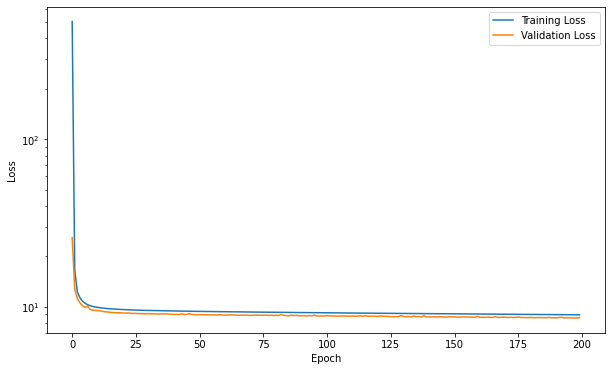

In [12]:
plt.rcParams["figure.figsize"] = (10,6)
mf.training_vs_validation_loss(fit_hist)

In [15]:
output = model.predict(clusters_v)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

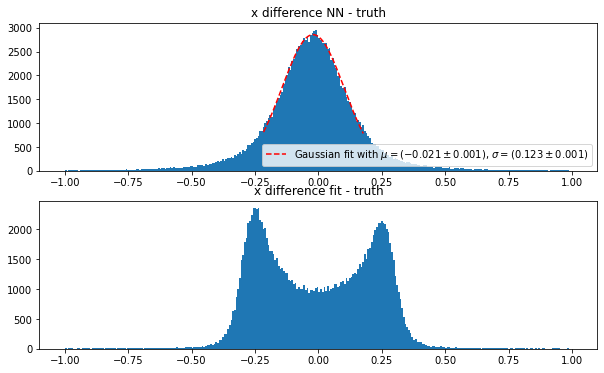

In [20]:
mf.histo_output(output.T[0], veri_fit_data.T[0], veri_truth_data.T[0], name="x", fit=True)

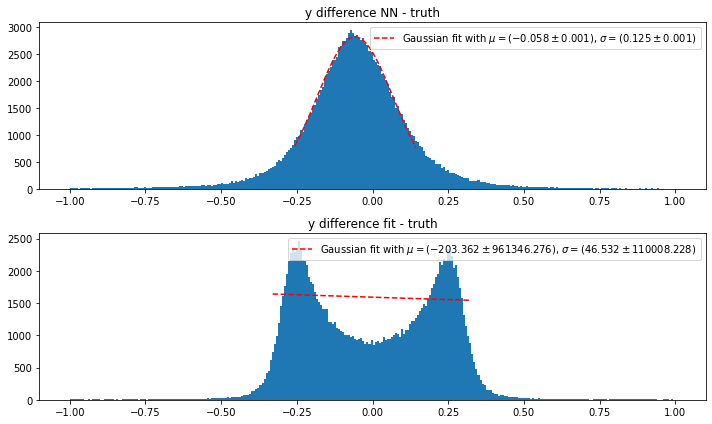

(array([-5.78837860e-02,  1.25342051e-01,  8.85570174e+02]),
 array([7.51694837e-04, 9.88868685e-04, 5.62585512e+00]),
 array([-2.03362422e+02,  4.65324619e+01,  2.60668143e+09]),
 array([9.61346276e+05, 1.10008228e+05, 1.23371768e+14]))

In [17]:
mf.histo_output(output.T[1], veri_fit_data.T[1], veri_truth_data.T[1], name="y")

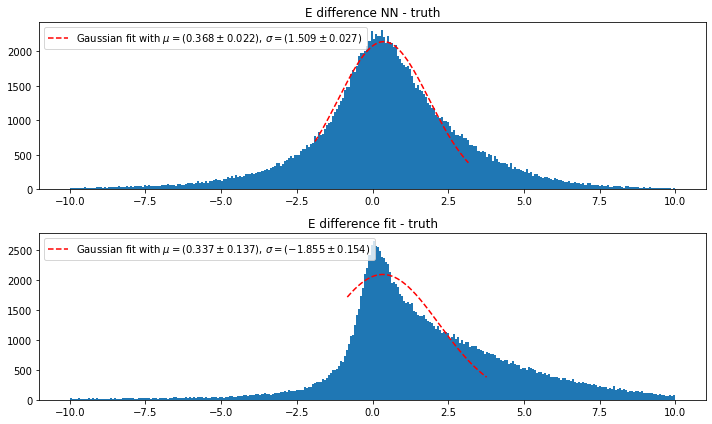

(array([3.67989985e-01, 1.50934264e+00, 8.09892391e+03]),
 array([2.16065612e-02, 2.73537226e-02, 1.19411657e+02]),
 array([ 3.36691567e-01, -1.85509098e+00,  9.70799030e+03]),
 array([1.37209754e-01, 1.54373648e-01, 7.36863988e+02]))

In [21]:
mf.histo_output(output.T[2], veri_fit_data.T[2], veri_truth_data.T[2], name="E", range_x=(-10,10), fit=True)

In [22]:

def gaus(x, mu, sigma, A):
    return (A/np.sqrt(2*np.pi * sigma**2))* np.exp(-(x-mu)**2 / (2*sigma**2))

def histo_output_rel(arr_NN, arr_fit, arr_truth, name='', figsave=False, range_x = (-1,1), bins=300, fit=True):
    '''takes output of neural network (either x,y OR E), the fit values (either x,y, OR E) and the true values of e,y or E. 
    Define with name which parameter (x,y,E) you gave as input'''
    
    plt.rcParams["figure.figsize"] = (10,6)
    plt.subplot(2,1,1)
    n_counts, bins, patches = plt.hist((arr_NN-arr_truth)/arr_truth, bins=bins, range=range_x)
    # fit
    if fit==True:
        maxv = n_counts.max()
        ind_fit = np.where(n_counts > 0.3*maxv)
        liml = ind_fit[0].min()
        limu = ind_fit[0].max() + 1

        x_centers = 0.5*(bins[:-1]+bins[1:])
        popt1, pcov1 = curve_fit(gaus, x_centers[liml:limu], n_counts[liml:limu], p0=[0,1, 100], sigma=1/np.sqrt(n_counts)[liml:limu], maxfev=10000)
        perr1 = np.sqrt(np.diag(pcov1))
        x_fit = np.linspace(x_centers[liml:limu][0], x_centers[liml:limu][-1], 500)
        y_fit = gaus(x_fit, *popt1)
        plt.plot(x_fit, y_fit, 'r--', label="Gaussian fit with " + r"$\mu = ({:.3f} \pm {:.3f})$".format(popt1[0], perr1[0]) + ", " + r"$\sigma = ({:.3f} \pm {:.3f})$".format(popt1[1], perr1[1]))
        plt.legend()
        plt.xlabel("relative difference of true and predicted value of " + name)
        plt.ylabel("counts")
        
        # which values does NN not learn correctly (energy)?
        ind_bad = np.where(n_counts < 0.4*maxv)
        values_bad = arr_NN[ind_bad]
    
    plt.subplot(2,1,2)
    n_counts, bins, patches = plt.hist((arr_fit-arr_truth)/arr_truth, bins=bins, range=range_x)

    
    if fit==True:
        # fit
        maxv = n_counts.max()
        ind_fit = np.where(n_counts > 0.3*maxv)
        liml = ind_fit[0].min()
        limu = ind_fit[0].max() + 1

        x_centers = 0.5*(bins[:-1]+bins[1:])
        popt2, pcov2 = curve_fit(gaus, x_centers[liml:limu], n_counts[liml:limu], p0=[0,1, 100], sigma=1/np.sqrt(n_counts)[liml:limu], maxfev=10000)
        perr2 = np.sqrt(np.diag(pcov2))
        x_fit = np.linspace(x_centers[liml:limu][0], x_centers[liml:limu][-1], 500)
        y_fit = gaus(x_fit, *popt2)
        plt.plot(x_fit, y_fit, 'r--', label="Gaussian fit with " + r"$\mu = ({:.3f} \pm {:.3f})$".format(popt2[0], perr2[0]) + ", " + r"$\sigma = ({:.3f} \pm {:.3f})$".format(popt2[1], perr2[1]))
        plt.legend()
        plt.xlabel("relative difference of true and coral fit value of " + name)
        plt.ylabel("counts")
    
    plt.tight_layout()
    if figsave == True:
        plt.savefig(name+"_histo.pdf")
    plt.show()
    
    if fit==True:
        #return popt1, perr1, popt2, perr2 
        return values_bad

In [23]:
from scipy.optimize import curve_fit

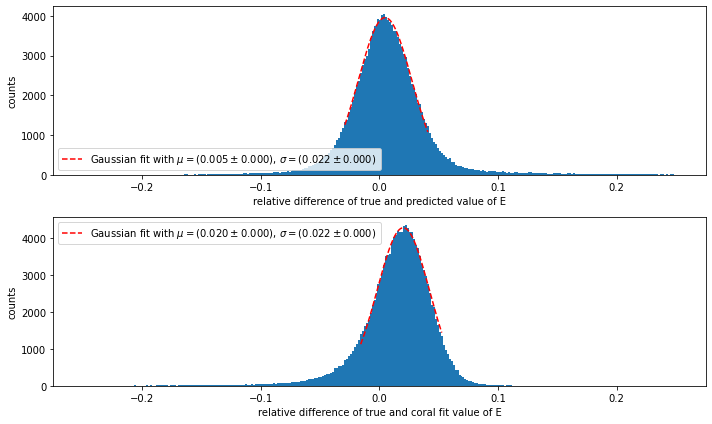

In [24]:
E_bad = histo_output_rel(output.T[2], veri_fit_data.T[2], veri_truth_data.T[2], name="E", range_x=(-0.25,0.25), fit=True)

In [25]:
keras.models.save_model(model, 'stage2model_corr_standardization')

INFO:tensorflow:Assets written to: stage2model_corr_standardization/assets
